# Creación del dataset iawe

Antes de nada necesitamos cargar las librerías pandas, matplotlib,networkx y el paquete nilmtk.

Asimismo realizaremos algunos otros ajustes.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import rcParams
from nilmtk.utils import print_dict
from nilmtk import DataSet
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

## Creación del fichero en formato  HDFS5 a partir de las medidas y los metadatos 

La primera tarea es la conversion de los diferentes ficheros de medidas en formato csv al formato HDFS5  (o simplificando H5), que almacenaramos en la carpeta `./data`. Además en el archivo h5, que va contener los datos recopilados,  tambien tendremos todos  los metadatos del dataset.

El timestamp arrojado  esta en  en formato 10 digitos (es decir almacena hasta los segundos pasados desde el 1 del 1 de 1970).El Timestamp en "timezone" para Almeria es "Europe/Madrid" https://www.epochconverter.com/.El resto de metadatos tienen que ver con la potencia (real,reactiva y aparente), el voltaje, la intensidad,la frecuencia y el factor de potencia.

Para cada fichero csv, que numeraremos del 1 al 12 corresponditntes a cada medidor (siendo el nº 1 el principal),en la clase convert_iawe, se sigue los siguintes pasos:

- Lectura del fichero numeado

- Conversión a formato fecha del campo timestamp

- Carga del resto de columnas

- Sort index

- Resample

- Reindexacion del fichero

Obviamente la clase  lanza este proceso para todos los ficheros de datos localizados en la carpeta de entrada \electricity\  usando  el fichero labels.csv


Por ultimo, asociamos los metadatos correspondientes ,leyendo los ficheros de la ruta C:\Users\XXXXX\anaconda3\envs\nilmtk-env\Lib\site-packages\nilmtk\dataset_converters\iawe\metadata. 


Los ficheros que usaremos como metadatos para incorporarlos al fichero H5 son los siguintes:

 - builiding1.yaml
 
 - dataset.yaml
 
 - meter_devices.yaml



Convertidos los metdatos y los datos a HDFS5, la primera tarea es la importación del dataset que se encuentra en formato HDF5 en la carpeta `./data`. Para ello, se carga el archivo dsual.h5 que contiene los datos recopilados y metadatos del dataset.

In [2]:
#dataset de referencia 
dsualm = DataSet('iawe.h5')


## MeterGroup y ElecMeter

Todos los conjuntos de datos constan de varios grupos de medidores de electricidad. 

Podemos agrupar los contadores por los siguintes criterios:
- Por viviendas en caso de haber mas viviendas por contador principal
- Por el tipo de aparato al que están conectados directamente
- Por frecuencia de muestreo
- O si el medidor es un "medidor de sitio" para toda la casa
- Si es un submedidor, a nivel de electrodomésticos, o incluso a nivel de circuito.

En NILMTK, una de las clases clave es MeterGroup, que almacena una lista de medidores y nos permite seleccionar un subconjunto de medidores, agregar energía de todos los medidores y muchas otras funciones.

Cuando abrimos por primera vez un DataSet, NILMTK crea varios objetosMeterGroup. Hay una clase llamada nilmtk.global_meter_group, la cual contiene todos los medidores cargados actualmente (incluso de varios conjuntos de datos si ha abierto más de un conjunto de datos). 

También hay un MeterGroup por edificio (que vive en el atributoBuilding.elec). También podemos anidar "MeterGroups" para agregar redes de fase dividida, red trifásica y aparatos de suministro dual (240 voltios) en conjuntos de datos de América del Norte y Canadá. 

En este punto, todos los metadatos se han cargado en la memoria pero ninguno de los datos de energía se ha cargado.
Cada edificio tiene un atributo "elec" que es un objeto "MeterGroup"y  que contiene los medidores "ElecMeter".

In [3]:
elec = dsualm.buildings[1].elec #todos los medidores del dataset
elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='iAWE', appliances=[Appliance(type='clothes iron', instance=1)])
  ElecMeter(instance=9, building=1, dataset='iAWE', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[A

Tenga en cuenta que podria haber grupos de medidores anidados: por ejemplo para un horno électrico y otro para la lavadora secadora (ambos son electrodomésticos de 240 voltios podrian tener dos medidores por electrodoméstico):

In [4]:
elec.nested_metergroups()

[]

Poner estos medidores en un grupo de medidores nos permite sumar fácilmente la demanda de energía registrada por ambos medidores para obtener la demanda de energía total para todo el aparato (pero también es muy fácil ver la demanda de energía del medidor individual).

Podemos obtener fácilmente un grupo de medidores(MeterGroup) de los submedidores o de la red.

In [5]:
elec.mains()

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
)

Podemos obtener fácilmente la suma de los datos de potencia de ambos medidores de red:

In [6]:
elec.mains().power_series_all_data().head()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


2013-05-24 05:30:00+05:30    282.744995
2013-05-24 05:30:01+05:30    288.757996
2013-05-24 05:30:02+05:30    288.757996
2013-05-24 05:30:03+05:30    297.394012
2013-05-24 05:30:04+05:30    303.722992
Freq: S, Name: (power, active), dtype: float32

Obtenemos los submedidores asociados al medidor principal

In [8]:
elec.submeters()

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='iAWE', appliances=[Appliance(type='clothes iron', instance=1)])
  ElecMeter(instance=9, building=1, dataset='iAWE', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=11, building=1, dataset='iAWE', appliances=[Appliance(type='wet appliance', instance=1)])
  Ele

### Etiquetas de dispositivos

Tenenos 12-2 medidores, por lo que podemos asociarle una etiqueta para identificarlos biunivocamente. 

In [9]:
 labels = pd.DataFrame({'Instances': list(range(1,13)),
                       'Meters': ['Medidor Princ.','M2', 'M.Fridge', 'M.AA', 'M.AA', 'M.Washing machine.','Computer','Clothes iron','unknown','tv','wet appliance','motor']})
Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]
    
    

##  Metadatos

Mediante el metodo print_dict podemos explorar los metadatos asociados al Dataset

In [10]:
print_dict(dsualm.metadata)  #metadatos del dataset

Asimismo podemos explorando los metadatos asociados al edificio

In [11]:
print_dict(dsualm.buildings[1].metadata) #Información del edificio 1 (instancia 1)

Veamos los metadados asociados a los sinte  aparatos de medida

In [12]:
print_dict(elec[1].get_metadata()) #metadatos de ElecMeter 1 o elec[1]

print_dict(elec[2].get_metadata()) #metadatos de ElecMeter 2 o elec[2]

print_dict(elec[3].get_metadata()) #metadatos de ElecMeter 3 o elec[3]

print_dict(elec[4].get_metadata()) #metadatos de ElecMeter 4 o elec[4]

print_dict(elec[5].get_metadata()) #metadatos de ElecMeter 5 o elec[5]

print_dict(elec[6].get_metadata()) #metadatos de ElecMeter 6 o elec[6]

print_dict(elec[7].get_metadata()) #metadatos de ElecMeter 6 o elec[6]

print_dict(elec[8].get_metadata()) #metadatos de ElecMeter 6 o elec[6]
print_dict(elec[9].get_metadata()) #metadatos de ElecMeter 6 o elec[6]
print_dict(elec[10].get_metadata()) #metadatos de ElecMeter 6 o elec[6]
print_dict(elec[11].get_metadata()) #metadatos de ElecMeter 6 o elec[6]
print_dict(elec[12].get_metadata()) #metadatos de ElecMeter 6 o elec[6]

# Estadísticas e información para medidores individuales

La clase 'ElecMeter' representa un solo medidor de electricidad. Cada ElecMeter tiene una lista de objetos de dispositivo asociados. Cada medidor puede estar asociado a uno o más electrodomésticos.ElecMeter tiene muchos de los mismos métodos de estadísticas que MeterGroup, como 'total_energy' , 'available_power_ac_types' , 'power_series', 'power_series_all_data'. 

Ahora exploraremos algunas funciones de estadísticas más (muchas de las cuales también están disponibles en MeterGroup) .

Vamos a  estudiar el medidor asociado a la nevera:

In [13]:
fridge_meter = elec['fridge']

Obtener el  medidor principal  superior o "de aguas arriba" (upstream meter)

In [14]:
fridge_meter.upstream_meter() # happens to be the mains meter group!

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
)

Metadatos sobre la clase de medidor

In [15]:
fridge_meter.device

{'max_sample_period': 300,
 'wireless': True,
 'measurements': [{'type': 'active',
   'upper_limit': 10000,
   'lower_limit': 0,
   'physical_quantity': 'power'},
  {'type': 'apparent',
   'upper_limit': 10000,
   'lower_limit': 0,
   'physical_quantity': 'power'},
  {'type': 'reactive',
   'upper_limit': 10000,
   'lower_limit': 0,
   'physical_quantity': 'power'},
  {'type': None,
   'upper_limit': 70,
   'lower_limit': 0,
   'physical_quantity': 'frequency'},
  {'type': None,
   'upper_limit': 270,
   'lower_limit': 0,
   'physical_quantity': 'voltage'},
  {'type': None,
   'upper_limit': 100,
   'lower_limit': 0,
   'physical_quantity': 'current'},
  {'type': None,
   'upper_limit': 1,
   'lower_limit': 0,
   'physical_quantity': 'power factor'}],
 'description': None,
 'sample_period': 1}

Aparato dominante:Si los metadatos especifican que un medidor tiene varios medidores conectados, entonces uno de ellos se puede especificar como el dispositivo 'dominante', y este dispositivo se puede recuperar con este método

In [16]:
fridge_meter.dominant_appliance()

Appliance(type='fridge', instance=1)

### Energia total

Algunos métodos estadísticos de MeterGroup permanecen en ElecMeter:

In [17]:
fridge_meter.total_energy() # kWh

apparent    99.967070
active      82.958385
reactive    53.965449
dtype: float64

Podemos optar por volcar todos los datos sobre el medidor de luminarias:

In [18]:
next(fridge_meter.load())

physical_quantity             voltage  frequency current      power  \
type                                                       apparent   
2013-06-07 05:30:00+05:30  235.070007  50.070000   0.011   2.486000   
2013-06-07 05:30:01+05:30  235.020004  50.080002   0.011   2.555000   
2013-06-07 05:30:02+05:30  234.979996  50.080002   0.011   2.485000   
2013-06-07 05:30:03+05:30  235.000000  50.060001   0.010   2.449000   
2013-06-07 05:30:04+05:30  234.949997  50.060001   0.011   2.519000   
...                               ...        ...     ...        ...   
2013-08-05 22:02:00+05:30  222.770004  50.169998   0.415  92.412003   
2013-08-05 22:02:01+05:30  222.779999  50.180000   0.416  92.584000   
2013-08-05 22:02:02+05:30  222.669998  50.160000   0.414  92.217003   
2013-08-05 22:02:03+05:30  222.690002  50.180000   0.415  92.366997   
2013-08-05 22:02:04+05:30  222.720001  50.160000   0.414  92.186996   

physical_quantity                                
type                          active   reactive  
2013-06-07 05:30:00+05:30   0.111000   2.483000  
2013-06-07 05:30:01+05:30   0.200000   2.547000  
2013-06-07 05:30:02+05:30   0.152000   2.480000  
2013-06-07 05:30:03+05:30   0.159000   2.444000  
2013-06-07 05:30:04+05:30   0.215000   2.510000  
...                              ...        ...  
2013-08-05 22:02:00+05:30  77.623001  50.146000  
2013-08-05 22:02:01+05:30  77.603996  50.490002  
2013-08-05 22:02:02+05:30  77.445999  50.062000  
2013-08-05 22:02:03+05:30  77.414001  50.387001  
2013-08-05 22:02:04+05:30  77.389000  50.095001  

[4538844 rows x 6 columns]

O cargar un generador que nos dará los valores en chunks. Más eficiente.

In [19]:
next (fridge_meter.power_series())

2013-06-07 05:30:00+05:30     0.111000
2013-06-07 05:30:01+05:30     0.200000
2013-06-07 05:30:02+05:30     0.152000
2013-06-07 05:30:03+05:30     0.159000
2013-06-07 05:30:04+05:30     0.215000
                               ...    
2013-08-05 22:02:00+05:30    77.623001
2013-08-05 22:02:01+05:30    77.603996
2013-08-05 22:02:02+05:30    77.445999
2013-08-05 22:02:03+05:30    77.414001
2013-08-05 22:02:04+05:30    77.389000
Name: (power, active), Length: 4538844, dtype: float32

### Obtener buenas secciones

Si graficamos los datos de potencia sin procesar, vemos que hay una gran brecha donde, supuestamente, el sistema de medición no estaba funcionando. (si tuviéramos que acercarnos, también veríamos muchos espacios más pequeños) con light_meter.plot.Podemos identificar automáticamente las 'secciones buenas' (es decir, las secciones donde cada par de muestras consecutivas es menor que 'max_sample_period` especificado en los metadatos del conjunto de datos):

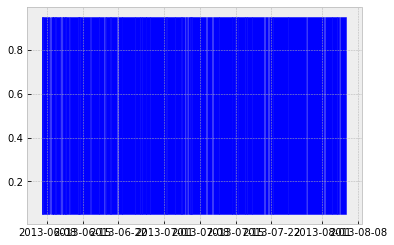

In [21]:
good_sections = fridge_meter.good_sections(full_results=True)
good_sections.plot()

Los fragmentos azules muestran dónde son buenos los datos. Una brecha blanca seria en datos incompletos en los datos de potencia bruta. Teoriacamente podria habermuchos huecos más pequeños que no podemos ver en este nivel de zoom.

También podemos ver las secciones exactas identificadas:

In [22]:
good_sections.combined()

[TimeFrame(start='2013-06-07 05:30:00+05:30', end='2013-06-07 06:03:15+05:30', empty=False),
 TimeFrame(start='2013-06-07 06:34:48+05:30', end='2013-06-07 06:35:31+05:30', empty=False),
 TimeFrame(start='2013-06-07 06:51:35+05:30', end='2013-06-07 08:33:00+05:30', empty=False),
 TimeFrame(start='2013-06-07 08:41:22+05:30', end='2013-06-08 12:36:37+05:30', empty=False),
 TimeFrame(start='2013-06-08 13:16:03+05:30', end='2013-06-08 13:42:24+05:30', empty=False),
 TimeFrame(start='2013-06-08 14:59:10+05:30', end='2013-06-08 16:33:18+05:30', empty=False),
 TimeFrame(start='2013-06-08 17:45:26+05:30', end='2013-06-08 19:47:39+05:30', empty=False),
 TimeFrame(start='2013-06-08 20:00:48+05:30', end='2013-06-08 21:42:55+05:30', empty=False),
 TimeFrame(start='2013-06-08 22:35:08+05:30', end='2013-06-09 08:08:14+05:30', empty=False),
 TimeFrame(start='2013-06-09 08:18:52+05:30', end='2013-06-09 08:21:49+05:30', empty=False),
 TimeFrame(start='2013-06-09 08:27:57+05:30', end='2013-06-09 10:10:35

## Dropout rate (tasa de deserción )

Además de que puede aparecer grandes lagunas debido a que todo el sistema está inactivo, también podemo teners pequeñas lagunas frecuentes debido a que algunos sensores  arrojan datos. A esto a veces se le llama "abandono". La tasa de abandono es un número entre 0 y 1 que especifica la proporción de muestras que faltan. Una tasa de abandono de 0 significa que no faltan muestras. Un valor de 1 significaría que faltan todas las muestras:

In [23]:
fridge_meter.dropout_rate()

0.08048524258487144

## Seleccion de subgrupos de medidores

Usamos ElecMeter.select_using_appliances () para seleccionar un nuevo MeterGroup usando un campo de metadatos. Por ejemplo, para obtener todas los neveras del conjunto de datos DSUALM::

In [24]:
import nilmtk
nilmtk.global_meter_group.select_using_appliances(type='fridge')

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
)

O seleccione varios tipos de aparatos:

In [25]:
elec.select_using_appliances(type=['fridge', 'computer'])

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
)

O todos los electrodomésticos del edificio 1 con motor de inducción monofásico (!):

In [26]:
nilmtk.global_meter_group.select_using_appliances(building=1, category='single-phase induction motor')

MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=12, building=1, dataset='iAWE', appliances=[Appliance(type='motor', instance=1)])
)

(NILMTK importa los 'metadatos comunes' del proyecto de metadatos NILM, que incluye una amplia gama de taxonomías de diferentes categorías)(http://nilm-metadata.readthedocs.org/en/latest/central_metadata.html#appliancetype))

## Medidas disponibles para cada medidor exceptuando la potencia

In [27]:
elec.available_physical_quantities() #todas las medidas del MeterGroup

['power factor', 'frequency', 'power', 'voltage', 'current']

In [28]:
elec[1].available_physical_quantities() #medidas de ElecMeter 1 (mains)



['power factor', 'frequency', 'power', 'voltage', 'current']

In [29]:
elec[2].available_physical_quantities() #medidas de ElecMeter 2 (boiler)


['power factor', 'frequency', 'power', 'voltage', 'current']

In [30]:
elec[3].available_physical_quantities() #medidas de ElecMeter 3 (fan)


['power factor', 'frequency', 'power', 'voltage', 'current']

In [31]:
elec[4].available_physical_quantities() #medidas de ElecMeter 4 (freezer)


['power factor', 'frequency', 'power', 'voltage', 'current']

In [32]:
elec[5].available_physical_quantities() #medidas de ElecMeter 5 (television)


['power factor', 'frequency', 'power', 'voltage', 'current']

In [33]:
elec[6].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)


['power factor', 'frequency', 'power', 'voltage', 'current']

In [34]:
elec[7].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)

['power factor', 'frequency', 'power', 'voltage', 'current']

In [35]:
elec[8].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)

['power factor', 'frequency', 'power', 'voltage', 'current']

In [36]:
elec[9].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)

['power factor', 'frequency', 'power', 'voltage', 'current']

In [37]:
elec[10].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)

['power factor', 'frequency', 'power', 'voltage', 'current']

In [38]:
elec[11].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)

['power factor', 'frequency', 'power', 'voltage', 'current']

In [39]:
elec[12].available_physical_quantities() #medidas de ElecMeter 6 (vacuum cleaner)

['power']

## Medidas disponibles relativas a la potencia


In [40]:
elec[1].available_ac_types('power') #medidas de potencia de ElecMeter 1 

['active', 'apparent', 'reactive']

In [41]:
elec[2].available_ac_types('power') #medidas de potencia de ElecMeter 2

['active', 'apparent', 'reactive']

In [42]:
elec[3].available_ac_types('power') #medidas de potencia de ElecMeter 3

['active', 'apparent', 'reactive']

In [43]:
elec[4].available_ac_types('power') #medidas de potencia de ElecMeter 4

['active', 'apparent', 'reactive']

In [44]:
elec[5].available_ac_types('power') #medidas de potencia de ElecMeter 5

['active', 'apparent', 'reactive']

In [45]:
elec[6].available_ac_types('power') #medidas de potencia de ElecMeter 6

['active', 'apparent', 'reactive']

Del atributo 'elec' se puede obtener información de los medidores

En caso de consultar por una medición en específico, se pueden usar los siguientes tipos de mediciones tanto en ‘available_physical_quantities’ como en ‘available_ac_types’: 'power', 'energy', 'cumulative energy', 'voltage', 'current', 'pf', 'frequency', 'power factor', 'state', 'phase angle'.

### Medidas disponibles por electrodomestico o aparato

Podemos  ver las medidas desde otro punto de vista

Veamos qué medidas tenemos para el frigorífico,hervidor,luz,tv,etc:

In [46]:
fridge = elec['fridge']
fridge.available_columns()

[('voltage', None),
 ('frequency', None),
 ('current', None),
 ('power', 'apparent'),
 ('power', 'active'),
 ('power factor', None),
 ('power', 'reactive')]

In [47]:
washing_machine = elec['washing machine']
washing_machine.available_columns()

[('voltage', None),
 ('frequency', None),
 ('current', None),
 ('power', 'apparent'),
 ('power', 'active'),
 ('power factor', None),
 ('power', 'reactive')]

In [48]:
computer = elec['computer']
computer.available_columns()

[('voltage', None),
 ('frequency', None),
 ('current', None),
 ('power', 'apparent'),
 ('power', 'active'),
 ('power factor', None),
 ('power', 'reactive')]

In [49]:
television = elec['television']
television.available_columns()

[('voltage', None),
 ('frequency', None),
 ('current', None),
 ('power', 'apparent'),
 ('power', 'active'),
 ('power factor', None),
 ('power', 'reactive')]

In [50]:
motor = elec['motor']
motor.available_columns()

[('power', 'active')]

## Resumen de mediciones

Ahora veamos un resumen de las medidas disponibles por cada medidor

In [56]:
print('Mediciones disponibles - Dataset: '+str(elec.available_physical_quantities()))
print('Mediciones de Potencia disponibles - Dataset: '+str(elec.available_ac_types('power')))

print('\nMedidas disponibles por cada medidor:')
for x in range(len(labels)):
    print(str(labels['Meters'][x])+': '+str(elec[x+1].available_physical_quantities()))

print('\nMedidas de potencia por cada medidor:')  
for x in range(len(labels)):
    print(str(labels['Meters'][x])+': '+str(elec[x+1].available_ac_types('power')))

Mediciones disponibles - Dataset: ['power factor', 'frequency', 'power', 'voltage', 'current']
Mediciones de Potencia disponibles - Dataset: ['apparent', 'active', 'reactive']

Medidas disponibles por cada medidor:
Medidor Princ.: ['power factor', 'frequency', 'power', 'voltage', 'current']
M2: ['power factor', 'frequency', 'power', 'voltage', 'current']
M.Fridge: ['power factor', 'frequency', 'power', 'voltage', 'current']
M.AA: ['power factor', 'frequency', 'power', 'voltage', 'current']
M.AA: ['power factor', 'frequency', 'power', 'voltage', 'current']
M.Washing machine.: ['power factor', 'frequency', 'power', 'voltage', 'current']
Computer: ['power factor', 'frequency', 'power', 'voltage', 'current']
Clothes iron: ['power factor', 'frequency', 'power', 'voltage', 'current']
unknown: ['power factor', 'frequency', 'power', 'voltage', 'current']
tv: ['power factor', 'frequency', 'power', 'voltage', 'current']
wet appliance: ['power factor', 'frequency', 'power', 'voltage', 'current']


Los dispositivos se identifican de forma única dentro de un edificio por un tipo (luces, televisión, etc.) y un número de instancia. Si no se especifica un número de instancia, ElecMeter recupera la instancia 1.

### Esquema de red

In [59]:
labels = pd.DataFrame({'Instances': list(range(1,13)),
                       'Meters': ['Medidor Princ.','M2', 'M.Fridge', 'M.AA', 'M.AA', 'M.Washing machine.','Computer','Clothes iron','unknown','tv','wet appliance','motor']})


In [62]:
 def draw_wiring_graph_2(self, show_meter_labels=True):
        graph = self.wiring_graph()
        
        try:
            # Try using graphviz layout...
            pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot')
            used_graphviz = True
        except:
            # ...and fallback to shell layout if graphviz is not installed or
            # doesn't work
            pos = nx.shell_layout(graph)
            used_graphviz = False
            
        meter_labels = {}
        if show_meter_labels:
            meter_labels = {meter: meter.label() for meter in graph.nodes()}
            for meter, name in meter_labels.items():
                x, y = pos[meter]

                if used_graphviz:
                    if meter.is_site_meter():
                        delta_y = 5
                    else:
                        delta_y = -5
                    
                    plt.text(x, y + delta_y, s=name, bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='center')
       

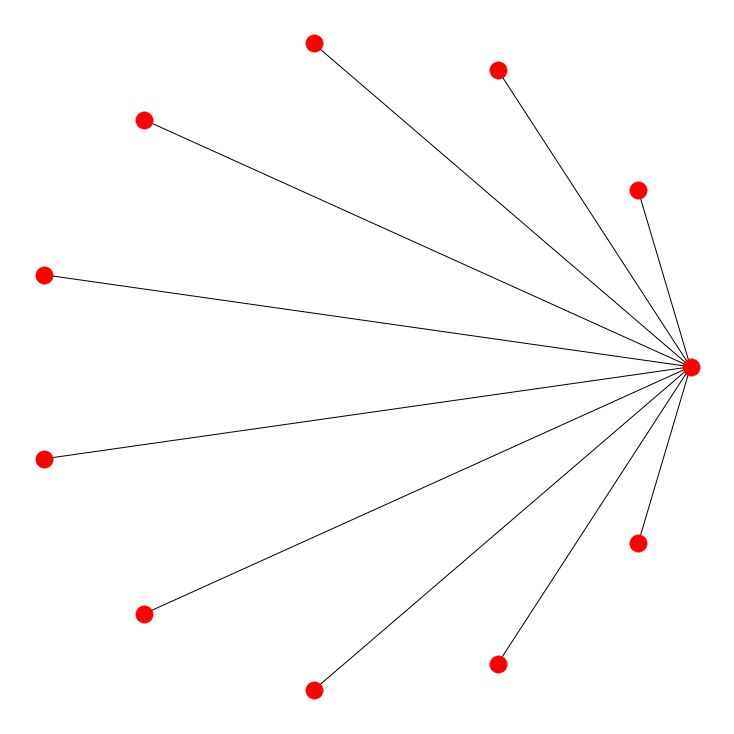

In [74]:
rcParams['figure.figsize'] = (10, 10)
fig = elec.draw_wiring_graph_2(show_meter_labels=False)

#etiquetas, opcional
#pos = nx.shell_layout(fig[0])
#nx.draw_networkx_labels(fig[0], pos, labels=Meters)

#guarda gráfico
plt.savefig('./data/images/2.1_Network.svg', bbox_inches='tight', transparent=True)
pass

NOTA: La funcion draw_wiring_graph  presenta problemas con Matplotlib 3.3.0 (y por tanto con NILMTK) segun issue 868 ( https://github.com/nilmtk/nilmtk/issues/868)), por lo que necesitamos reemplazar la función original para poder representar graficamente correctamente las etiquetas, por lo que vamos a crear la nueva funcion elec.draw_wiring_graph_2 que guardaremos en la ruta \user\USUARIO\anaconda3\envs\nilmtk-env\Lib\site-packages\nilmtk\metergroup.py

## Carga de datos en memoria

Intervalos de tiempo en que se registran datos: `elec[1]`

Timestamp en "timezone" es  "Europe/Madrid" https://www.epochconverter.com/

In [64]:
elec.get_timeframe()

TimeFrame(start='2013-05-24 05:30:00+05:30', end='2013-09-18 08:40:55+05:30', empty=False)

Una manera rápida de cargar varios datos de medidores en un DataFrame es utilizar la función `dataframe_of_meters` e indicar cual medida se desea importar desde el MeterGroup.

Observese que solo podemos tomar datos de potencia :active', 'apparent', 'reactive'.




Vamos a mostrar la potencia activa de los medidores del 2 al 6 (es decir todos menos el principal). 

In [65]:
Devices = elec.select(instance=[3,4,5,6,7,8,9,10,11,12])  #nuevo MeterGroup de dispositivos
df = Devices.dataframe_of_meters(ac_type='active') # active crea Dataframe badado en la potencia Valid AC types = ['active', 'apparent', 'reactive'].
#etiquetas
df.columns = [list(labels['Meters'][1:11])]
df

,M2,M.Fridge,M.AA,M.AA,M.Washing machine.,Computer,Clothes iron,unknown,tv,wet appliance
2013-05-30 12:51:36+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-05-30 12:51:42+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-05-30 12:51:48+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-05-30 12:51:54+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2013-05-30 12:52:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
2013-09-18 08:40:30+05:30,NaN,1.319000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-18 08:40:36+05:30,NaN,1.345333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-18 08:40:42+05:30,NaN,1.332167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-18 08:40:48+05:30,NaN,1.301333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se puede obtener el tipo de datos usado para cada medidor usandola clase info

In [66]:
df.info() #información del DataFrame

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1595894 entries, 2013-05-30 12:51:36+05:30 to 2013-09-18 08:40:54+05:30
Freq: 6S
Data columns (total 10 columns):
(M2,)                    859521 non-null float32
(M.Fridge,)              1476062 non-null float32
(M.AA,)                  1410055 non-null float32
(M.AA,)                  795280 non-null float32
(M.Washing machine.,)    858875 non-null float32
(Computer,)              833570 non-null float32
(Clothes iron,)          593261 non-null float32
(unknown,)               781929 non-null float32
(tv,)                    349740 non-null float32
(wet appliance,)         520102 non-null float32
dtypes: float32(10)
memory usage: 73.1 MB


Podemos asignar individualmente datos de medidores en un Dataframe




Vemos para el meter nº 3(fridge) con datos capturados de 10:16 a 12:58 tenemos la siguinte tabla que nos muestra todas las medidas

In [67]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 12:58:00+01:00' #tiempo final


df_vac = next(elec[6].load())[t0:t1] #DataFrame medidor 
df_vac

physical_quantity             voltage  frequency current       power  \
type                                                        apparent   
2013-06-10 07:02:00+05:30  189.080002  49.990002   0.758  143.412994   
2013-06-10 07:02:01+05:30  189.240005  50.009998   0.781  147.798996   
2013-06-10 07:02:02+05:30  189.020004  49.990002   0.792  149.634003   
2013-06-10 07:02:03+05:30  189.210007  50.000000   0.782  148.007004   
2013-06-10 07:02:04+05:30  189.089996  49.990002   0.786  148.656998   
...                               ...        ...     ...         ...   
2013-08-04 12:29:55+05:30  230.169998  50.060001   0.916  210.847000   
2013-08-04 12:29:56+05:30  229.979996  50.080002   0.931  214.214005   
2013-08-04 12:29:57+05:30  230.059998  50.049999   0.885  203.677994   
2013-08-04 12:29:58+05:30  229.919998  50.060001   0.929  213.619003   
2013-08-04 12:29:59+05:30  229.779999  50.049999   0.918  210.841995   

physical_quantity                                 
type                           active   reactive  
2013-06-10 07:02:00+05:30  140.438995 -29.054001  
2013-06-10 07:02:01+05:30  144.858994 -29.332001  
2013-06-10 07:02:02+05:30  146.755005 -29.215000  
2013-06-10 07:02:03+05:30  145.091003 -29.237000  
2013-06-10 07:02:04+05:30  145.709000 -29.457001  
...                               ...        ...  
2013-08-04 12:29:55+05:30  208.826996 -29.115000  
2013-08-04 12:29:56+05:30  212.048996 -30.378000  
2013-08-04 12:29:57+05:30  201.774994 -27.777000  
2013-08-04 12:29:58+05:30  211.514999 -29.902000  
2013-08-04 12:29:59+05:30  208.744003 -29.672001  

[23740 rows x 6 columns]

Se puede visualizar solo la cabecera de los datos

In [68]:
df_vac.head()

physical_quantity             voltage  frequency current       power  \
type                                                        apparent   
2013-06-10 07:02:00+05:30  189.080002  49.990002   0.758  143.412994   
2013-06-10 07:02:01+05:30  189.240005  50.009998   0.781  147.798996   
2013-06-10 07:02:02+05:30  189.020004  49.990002   0.792  149.634003   
2013-06-10 07:02:03+05:30  189.210007  50.000000   0.782  148.007004   
2013-06-10 07:02:04+05:30  189.089996  49.990002   0.786  148.656998   

physical_quantity                                 
type                           active   reactive  
2013-06-10 07:02:00+05:30  140.438995 -29.054001  
2013-06-10 07:02:01+05:30  144.858994 -29.332001  
2013-06-10 07:02:02+05:30  146.755005 -29.215000  
2013-06-10 07:02:03+05:30  145.091003 -29.237000  
2013-06-10 07:02:04+05:30  145.709000 -29.457001

### Proporcion de energia submedida

Calculemos la proporción de energía submedida en el edificio 1:

In [69]:
elec.proportion_of_energy_submetered()

Running MeterGroup.proportion_of_energy_submetered...
Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='iAWE') ...    total_energy for ElecMeterID(instance=2, building=1, dataset='iAWE') ...   

0.5897915580116893

Tenga en cuenta que NILMTK ha emitido una advertencia de que Mains usa un tipo diferente de medición de potencia que todos los submedidores, por lo que no es una comparación del todo precisa. Lo que plantea la pregunta: ¿qué tipo de medidas de potencia se utilizan para la red y los submedidores? Vamos a averiguar.

### Carga una columna simple de datos de  potencia

Usar fan.power_series() que devuelve un generador de objetos pandas.Series unidimensionales, cada uno de los cuales contiene datos de energía utilizando el tipo de CA más 'sensible':

In [70]:
series = next(motor.power_series())
series.head()

2013-05-30 12:51:41+05:30    0.0
2013-05-30 12:51:47+05:30    0.0
2013-05-30 12:51:53+05:30    0.0
2013-05-30 12:51:59+05:30    0.0
2013-05-30 12:52:05+05:30    0.0
Name: (power, active), dtype: float32

o, para obtener potencia reactiva:

### Especificar cantidad_física o tipo de CA

Para cargar datos de voltaje:

In [76]:
df = next(fridge.load(physical_quantity='voltage'))
df.head()

physical_quantity,voltage
type,
2013-06-07 05:30:00+05:30,235.070007
2013-06-07 05:30:01+05:30,235.020004
2013-06-07 05:30:02+05:30,234.979996
2013-06-07 05:30:03+05:30,235.000000
2013-06-07 05:30:04+05:30,234.949997


In [77]:
df = next(fridge.load(physical_quantity = 'power'))
df.head()

physical_quantity            power                
type                      apparent active reactive
2013-06-07 05:30:00+05:30    2.486  0.111    2.483
2013-06-07 05:30:01+05:30    2.555  0.200    2.547
2013-06-07 05:30:02+05:30    2.485  0.152    2.480
2013-06-07 05:30:03+05:30    2.449  0.159    2.444
2013-06-07 05:30:04+05:30    2.519  0.215    2.510

### Cargando especificando el tipo de CA

In [78]:
df = next(fridge.load(ac_type='active'))
df.head()

physical_quantity,power
type,active
2013-06-07 05:30:00+05:30,0.111
2013-06-07 05:30:01+05:30,0.200
2013-06-07 05:30:02+05:30,0.152
2013-06-07 05:30:03+05:30,0.159
2013-06-07 05:30:04+05:30,0.215


### Cargando por remuestreo a un período específico

In [79]:
# resample por minutos (i.e. con un simple periodo de  60 secs)
df = next(fridge.load(ac_type='active', sample_period=60))
df.head()

physical_quantity,power
type,active
2013-06-07 05:30:00+05:30,0.157583
2013-06-07 05:31:00+05:30,0.160567
2013-06-07 05:32:00+05:30,0.158170
2013-06-07 05:33:00+05:30,105.332802
2013-06-07 05:34:00+05:30,120.265068


# Estadisticas para MeterGroups

Calculemos la proporción de energía submedida en el edificio 1 de REDD:

In [80]:
elec.proportion_of_energy_submetered()

Running MeterGroup.proportion_of_energy_submetered...
Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='iAWE') ...   

0.5897915580116893

### Energia Total

In [81]:
elec.mains().total_energy() # returns kWh

Calculating total_energy for ElecMeterID(instance=2, building=1, dataset='iAWE') ...   

apparent    1430.854277
active      1366.069880
reactive     127.476065
dtype: float64

In [82]:
#energía por submedidor kwH diaria promedio
d1=elec.energy_per_meter(ac_type=['active'], per_period='D').round(2) # kWh, per_period='D'
#energía por submedidor kwH semanal promedio
d2=elec.energy_per_meter(ac_type=['active'], per_period='W').round(2) # kWh, per_period='W'
#energía por submedidor kwH total
d3=elec.energy_per_meter(ac_type=['active']).round(2) # kWh, per_period='D'

df=d1.append([d2,d3]).drop(index=['apparent', 'reactive']).transpose()
df.index = [list(labels['Meters'])]
df.columns = ['kWh Día','kWh Sem.','Total kWh']
df

12/12 ElecMeter(instance=12, building=1, dataset='iAWE', appliances=[Appliance(type='motor', instance=1)])nce=1)])

,kWh Día,kWh Sem.,Total kWh
Medidor Princ.,4.89,34.26,360.50
M2,13.65,95.58,1005.57
M.Fridge,1.39,9.73,82.96
M.AA,1.99,13.90,203.57
M.AA,2.08,14.58,203.89
M.Washing machine.,0.04,0.27,2.15
Computer,0.41,2.86,24.35
Clothes iron,0.02,0.11,0.89
unknown,0.02,0.12,0.72
tv,0.21,1.48,11.50


### Energia por submedidor

Veamos la energia  para el submedidor

In [83]:
energy_per_meter = elec.submeters().energy_per_meter() # kWh, again
energy_per_meter

10/10 ElecMeter(instance=12, building=1, dataset='iAWE', appliances=[Appliance(type='motor', instance=1)])ce=1)]))

,"(3, 1, iAWE)","(4, 1, iAWE)","(5, 1, iAWE)","(6, 1, iAWE)","(7, 1, iAWE)","(8, 1, iAWE)","(9, 1, iAWE)","(10, 1, iAWE)","(11, 1, iAWE)","(12, 1, iAWE)"
active,82.958385,203.569523,203.889213,2.152638,24.351512,0.885766,0.722616,11.495919,0.558717,1.067078
apparent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Los encabezados de columna son los números de instancia de ElecMeter.

La funcion `fraction_per_meter` lo mismo que `energy_per_submeter` excepto que devuelve la fraccion de energia por medidor

Seleccionar contadores en función de su consumo energético

Hagamos un nuevo MeterGroup que solo contenga los ElecMeters que usaron más de 20 kWh:

In [84]:
# energy_per_meter es un DataFrame donde cada fila es un
# tipo de potencia ('activa', 'reactiva' o 'aparente').
# Todos los medidores de electrodomésticos en REDD están registrados como 'activos', así que seleccione
# la fila 'activa':
energy_per_meter = energy_per_meter.loc['active']
more_than_20 = energy_per_meter[energy_per_meter > 20]
more_than_20

(3, 1, iAWE)     82.958385
(4, 1, iAWE)    203.569523
(5, 1, iAWE)    203.889213
(7, 1, iAWE)     24.351512
Name: active, dtype: float64

In [85]:
instances = more_than_20.index
instances

Index([(3, 1, 'iAWE'), (4, 1, 'iAWE'), (5, 1, 'iAWE'), (7, 1, 'iAWE')], dtype='object')

### Trazar la fracción del consumo de energía de cada aparato

In [86]:
fraction = elec.submeters().fraction_per_meter().dropna()

10/10 ElecMeter(instance=12, building=1, dataset='iAWE', appliances=[Appliance(type='motor', instance=1)])ce=1)]))

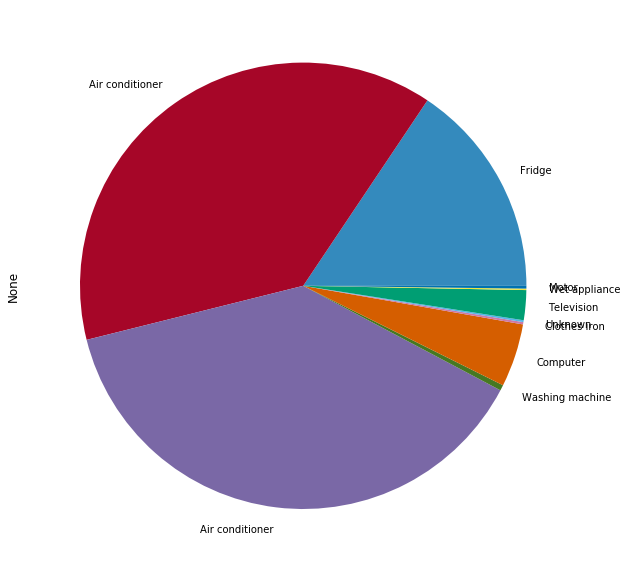

In [87]:
# Creacion de convenientes etiquetas
labels = elec.get_labels(fraction.index)
plt.figure(figsize=(10,30))
fraction.plot(kind='pie', labels=labels);

## Gráficos

### Fridge  (appliance 3)

Veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 6 (Vacuum Cleaner).Primero veamos el timeframe.

In [88]:
fridge.get_timeframe()
#light.plot()

TimeFrame(start='2013-06-07 05:30:00+05:30', end='2013-08-05 22:02:04+05:30', empty=False)

Ahora vamos a mostrar los diferentes de la potencia, tension y corriente

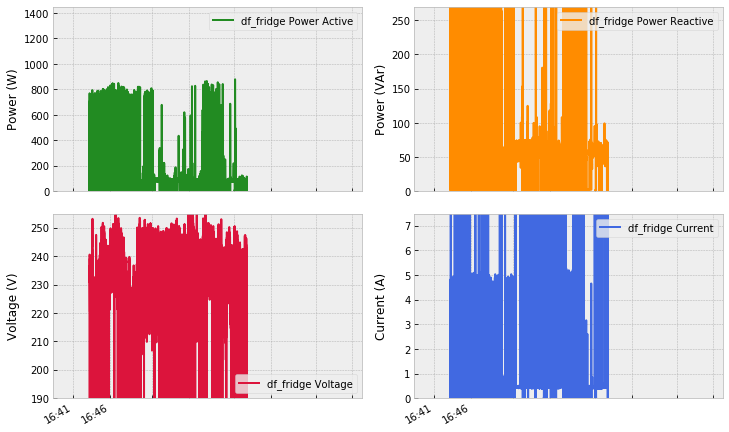

In [100]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[3].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_fridge Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_fridge Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_fridge Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_fridge Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass

Una nevera esta compuesta basicamente por un compresor  y su electronica asociada,motivo por el cual vemos un pico de potencia reactiva coincidiendo con el arranque del motor con su correspondiente pico de consumo y el potencia.

## Aire  Acondicionado (appliances   4 y 5 )

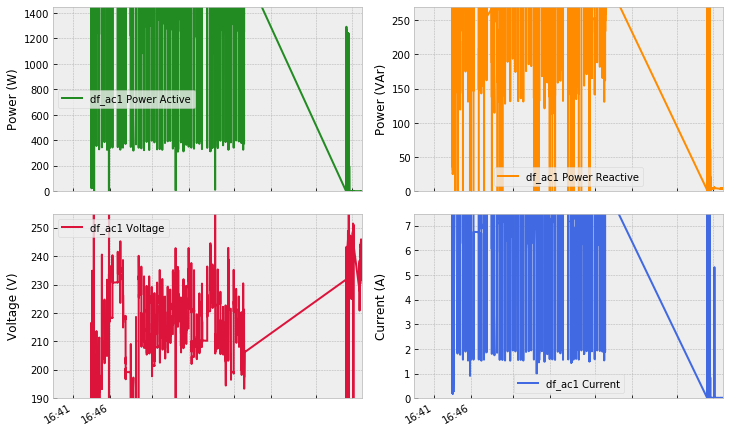

In [101]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[4].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_ac1 Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_ac1 Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_ac1 Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_ac1 Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_motor.svg', bbox_inches='tight', transparent=True)
pass

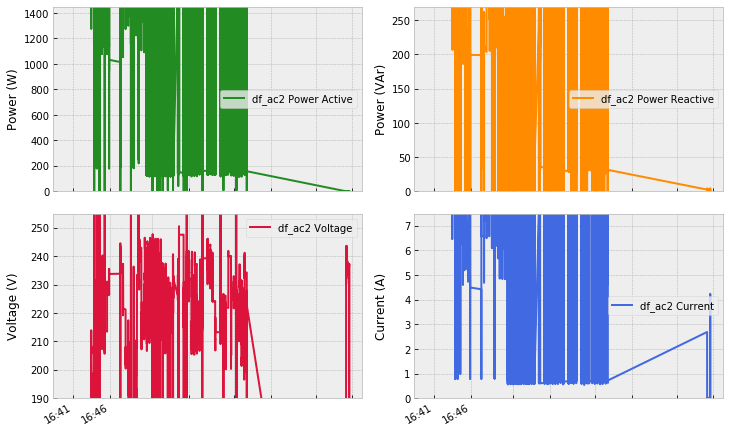

In [102]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[5].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_ac2 Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_ac2 Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_ac2 Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_ac2 Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_motor.svg', bbox_inches='tight', transparent=True)
pass

### Washing machine ( appliance 6)

Veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 6

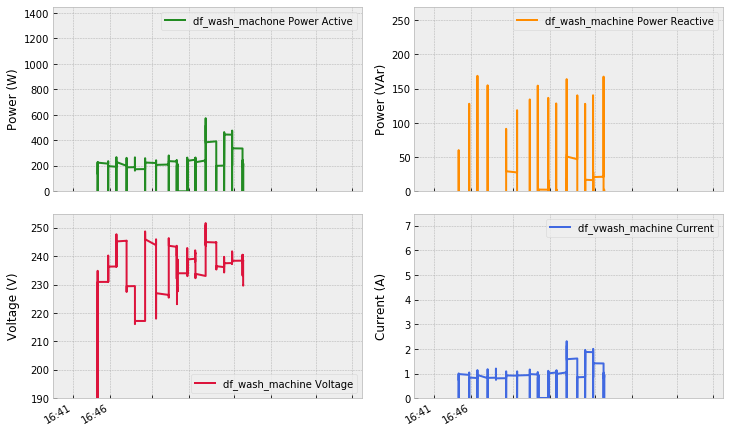

In [90]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[6].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_wash_machone Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_wash_machine Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_wash_machine Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_vwash_machine Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass

### Computer (appliance 7)

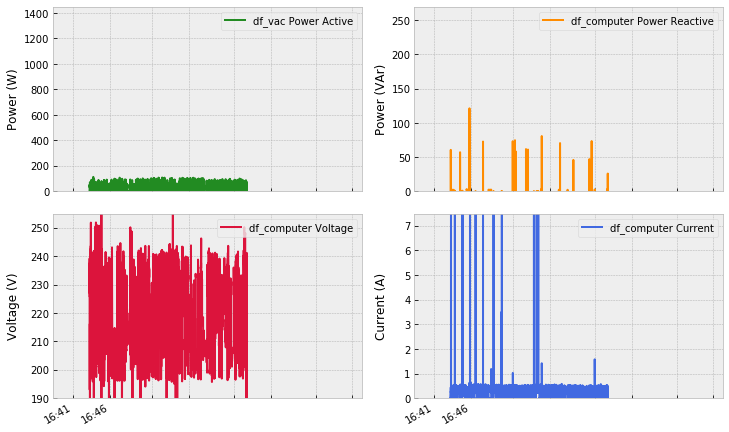

In [91]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[7].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_vac Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_computer Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_computer Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_computer Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_comp.svg', bbox_inches='tight', transparent=True)
pass

### Clothes iron (appliance 8)

Veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 7 (Light)

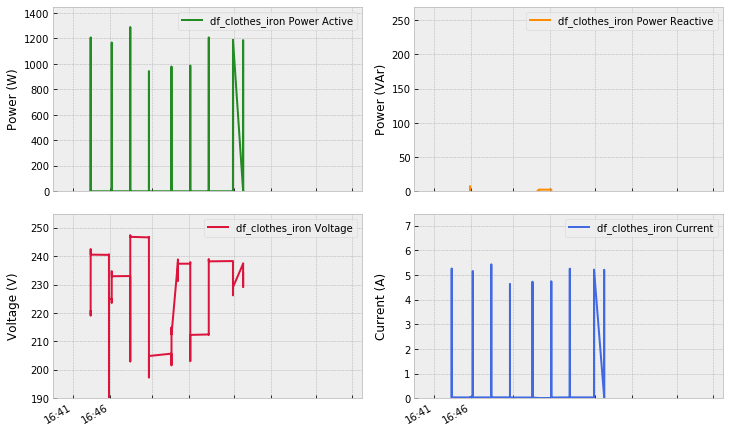

In [103]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[8].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_clothes_iron Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_clothes_iron Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_clothes_iron Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_clothes_iron Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_motor.svg', bbox_inches='tight', transparent=True)
pass

### Unknown ( appliance 9)

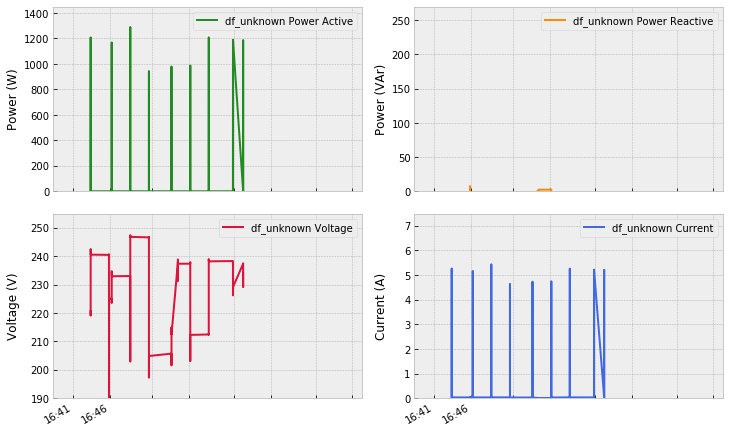

In [104]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[8].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_unknown Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_unknown Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_unknown Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_unknown Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_motor.svg', bbox_inches='tight', transparent=True)
pass

### Television (appliance 10)

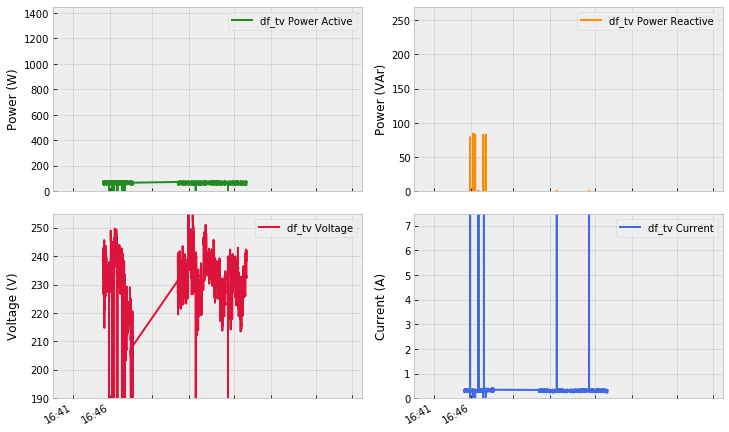

In [105]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[10].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_tv Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_tv Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_tv Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_tv Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_motor.svg', bbox_inches='tight', transparent=True)
pass

### wet appliance (appliance 11)

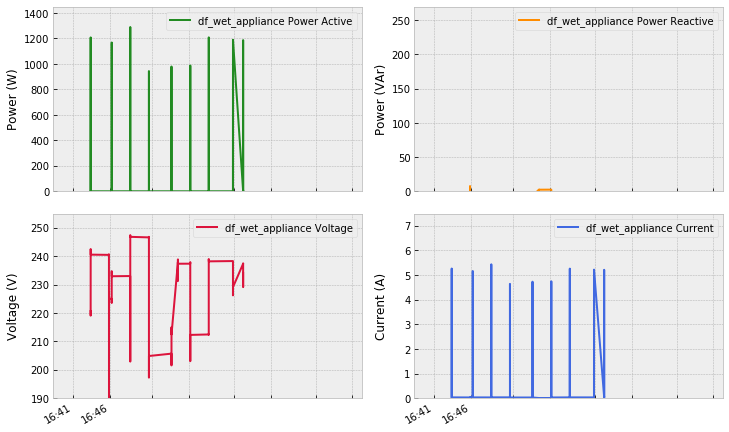

In [106]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[8].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_wet_appliance Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_wet_appliance Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])

df_vac['voltage'].plot(ax=ax3,color='crimson')
ax3.legend(['df_wet_appliance Voltage'])
ax3.set(ylabel='Voltage (V)')
ax3.set_ylim([190,255])

df_vac['current'].plot(ax=ax4,color='royalblue')
ax4.legend(['df_wet_appliance Current'])
ax4.set(ylabel='Current (A)')
ax4.set_ylim([0,7.5])


ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_motor.svg', bbox_inches='tight', transparent=True)
pass

### M.Principal ( app 1)

Por ultimo veamos ahora en forma de grafico las potencias activa y reactiva junto a la tension y la corriente para el medidor numero 5 (TV)

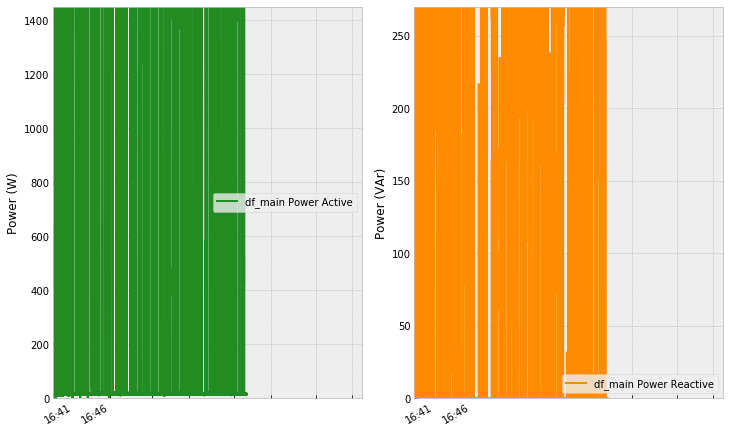

In [112]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[1].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_main Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_main Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])



ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass

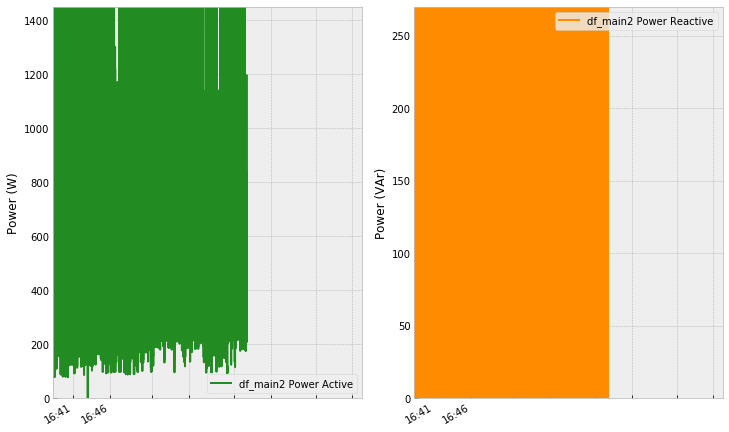

In [113]:
t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final


df_vac = next(elec[2].load())[t0:t1] #DataFrame medidor 

#graficos

rcParams['figure.figsize'] = (12, 8)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, gridspec_kw={'hspace': 0.12, 'wspace': 0.17})

df_vac['power', 'active'].plot(ax=ax1,color='forestgreen')
ax1.legend(['df_main2 Power Active'])
ax1.set(ylabel='Power (W)')
ax1.set_ylim([0,1450])

df_vac['power', 'reactive'].plot(ax=ax2,color='darkorange')
ax2.legend(['df_main2 Power Reactive'])
ax2.set(ylabel='Power (VAr)')
ax2.set_ylim([0,270])



ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['16:41','16:46'])
fig.align_ylabels([(ax1,ax2,ax3,ax4)])

#guarda gráfico
plt.savefig('./data/images/df_vac.svg', bbox_inches='tight', transparent=True)
pass

### Trazar los electrodomésticos cuando estén en uso

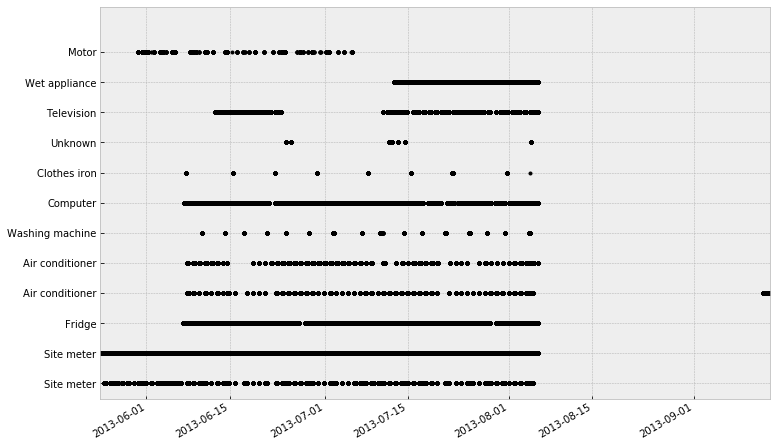

In [114]:
#sns.set_palette("Set3", n_colors=12)
# Set a threshold to remove residual power noise when devices are off
elec.plot_when_on(on_power_threshold = 40)

## Trazar datos submedidos para un solo día

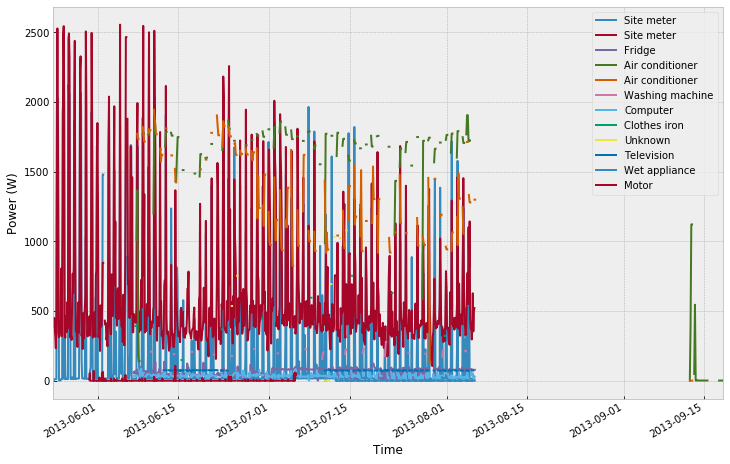

In [115]:
dsualm.set_window(start='2013-05-24', end='2013-05-25')
elec.plot();
plt.xlabel("Time");

## Gráfico de autocorrelación

In [7]:
from pandas.plotting import autocorrelation_plot

In [ ]:
elec.mains().plot_autocorrelation();

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


## Cambio en el muestreo de datos

Al cambiar el muestro de datos, NILMTK utiliza por defecto el método mean o media aritmética el cual calculará un promedio de los valores que se encuentren de la serie de tiempo, divididos en grupos correspondientes al nuevo periodo de muestreo. Además de este método se pueden especificar otros tales como el primer dato válido (first), la mediana (median), el valor más cercano (nearest), o utilizar el valor inmediatamente posterior (ffill o pad), entre otros.

### Energia activa

Vamos ahora analizar la potencia  activa correspondiente el contador global  usando diferentes periodos de muestreo

In [4]:
m = 1 #meter
method1 = {'how': 'mean'}
method2 = {'how': 'median'}
method3 = {'how': 'first'}

#medición original, cada 1 segundo
df_1s   = next(elec[m].load(ac_type='active',sample_period=1,       resample_kwargs=method1))
#resamples
df1_10s  = next(elec[m].load(ac_type='active', sample_period=10,     resample_kwargs=method1))
df1_30s  = next(elec[m].load(ac_type='active', sample_period=30,     resample_kwargs=method1))
df1_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,   resample_kwargs=method1))
df1_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,   resample_kwargs=method1))
df1_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method1))
df1_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method1))
df1_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method1))

df2_10s  = next(elec[m].load(ac_type='active', sample_period=10,    resample_kwargs=method2))
df2_30s  = next(elec[m].load(ac_type='active', sample_period=30,    resample_kwargs=method2))
df2_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,  resample_kwargs=method2))
df2_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,  resample_kwargs=method2))
df2_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method2))
df2_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method2))
df2_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method2))

df3_10s  = next(elec[m].load(ac_type='active', sample_period=10,    resample_kwargs=method3))
df3_30s  = next(elec[m].load(ac_type='active', sample_period=30,    resample_kwargs=method3))
df3_60s  = next(elec[m].load(ac_type='active', sample_period=60*1,  resample_kwargs=method3))
df3_5m   = next(elec[m].load(ac_type='active', sample_period=60*5,  resample_kwargs=method3))
df3_10m  = next(elec[m].load(ac_type='active', sample_period=60*10,  resample_kwargs=method3))
df3_15m  = next(elec[m].load(ac_type='active', sample_period=60*15,  resample_kwargs=method3))
df3_30m  = next(elec[m].load(ac_type='active', sample_period=60*30,  resample_kwargs=method3))

#dataframe completo
dfs1=[df_1s,df1_10s,df1_30s,df1_60s,df1_5m,df1_10m,df1_15m,df1_30m]
#dataframe completo
dfs2=[df_1s,df2_10s,df2_30s,df2_60s,df2_5m,df2_10m,df2_15m,df2_30m]
#dataframe completo
dfs3=[df_1s,df3_10s,df3_30s,df3_60s,df3_5m,df3_10m,df3_15m,df3_30m]

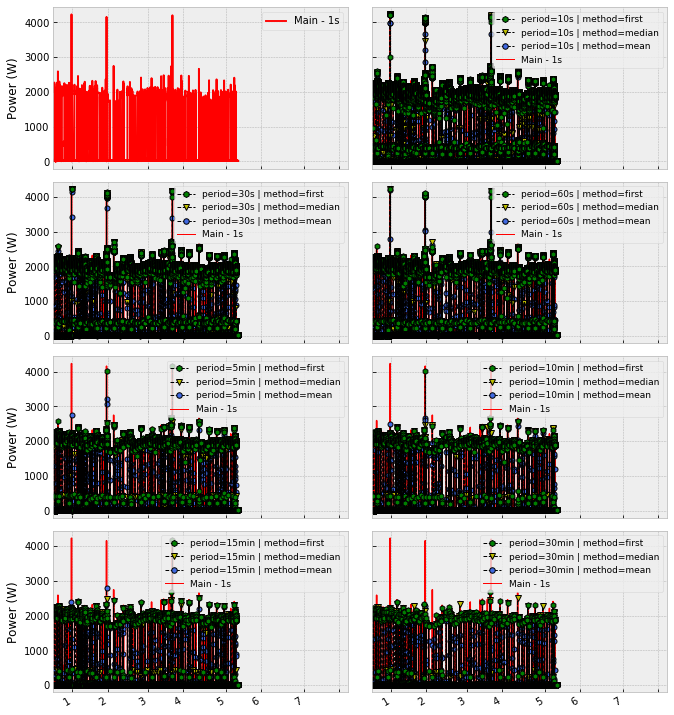

In [5]:
rcParams['figure.figsize'] = (11, 14)

t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final

labels_ = ['Main - 1s','10s','30s','60s','5min','10min','15min','30min']
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, sharex=True, sharey=True,
                                                                   gridspec_kw={'hspace': 0.08, 'wspace': 0.08})
i = 1
for ax in fig.get_axes():   
    if ax == ax1:
        df_1s[t0:t1].plot(ax=ax,linewidth=1.9,color='r')
        ax.legend([labels_[0]])               
    else:
        import matplotlib.lines as mlines
        df_1s[t0:t1].plot(ax=ax,linewidth=1.5,color='r') 
        dfs1[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="o", markersize=5, markerfacecolor='royalblue')    
        dfs2[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="v", markersize=5.5, markerfacecolor='y')
        dfs3[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="h", markersize=5.5, markerfacecolor='g')
        #etiquetas
        line0 = mlines.Line2D([], [], lw=1, c='red', label= labels_[0])
        line1 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="o", markersize=5.5,
                              markerfacecolor='royalblue', label='period='+labels_[i]+' | method=mean')
        line2 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="v", markersize=6,
                              markerfacecolor='y', label='period='+labels_[i] + ' | method=median')
        ax.legend(handles=[line2, line1, line0], fontsize=9)
        line3 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="h", markersize=6,
                              markerfacecolor='g', label='period='+labels_[i] + ' | method=first')
        ax.legend(handles=[line3, line2, line1, line0], fontsize=9)
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
        i = i+1
    ax.set(ylabel='Power (W)')

ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['1','2','3','4','5','6','7'])

#guarda gráfico
plt.savefig('./data/images/2.3_Resample.svg', bbox_inches='tight', transparent=True)
pass

### Energia reactiva

In [6]:
m = 1 #meter
method1 = {'how': 'mean'}
method2 = {'how': 'median'}
method3 = {'how': 'first'}

#medición original, cada 1 segundo
df_1s   = next(elec[m].load(ac_type='reactive',sample_period=1,       resample_kwargs=method1))
#resamples
df1_10s  = next(elec[m].load(ac_type='reactive', sample_period=10,     resample_kwargs=method1))
df1_30s  = next(elec[m].load(ac_type='reactive', sample_period=30,     resample_kwargs=method1))
df1_60s  = next(elec[m].load(ac_type='reactive', sample_period=60*1,   resample_kwargs=method1))
df1_5m   = next(elec[m].load(ac_type='reactive', sample_period=60*5,   resample_kwargs=method1))
df1_10m  = next(elec[m].load(ac_type='reactive', sample_period=60*10,  resample_kwargs=method1))
df1_15m  = next(elec[m].load(ac_type='reactive', sample_period=60*15,  resample_kwargs=method1))
df1_30m  = next(elec[m].load(ac_type='reactive', sample_period=60*30,  resample_kwargs=method1))

df2_10s  = next(elec[m].load(ac_type='reactive', sample_period=10,    resample_kwargs=method2))
df2_30s  = next(elec[m].load(ac_type='reactive', sample_period=30,    resample_kwargs=method2))
df2_60s  = next(elec[m].load(ac_type='reactive', sample_period=60*1,  resample_kwargs=method2))
df2_5m   = next(elec[m].load(ac_type='reactive', sample_period=60*5,  resample_kwargs=method2))
df2_10m  = next(elec[m].load(ac_type='reactive', sample_period=60*10,  resample_kwargs=method2))
df2_15m  = next(elec[m].load(ac_type='reactive', sample_period=60*15,  resample_kwargs=method2))
df2_30m  = next(elec[m].load(ac_type='reactive', sample_period=60*30,  resample_kwargs=method2))

df3_10s  = next(elec[m].load(ac_type='reactive', sample_period=10,    resample_kwargs=method3))
df3_30s  = next(elec[m].load(ac_type='reactive', sample_period=30,    resample_kwargs=method3))
df3_60s  = next(elec[m].load(ac_type='reactive', sample_period=60*1,  resample_kwargs=method3))
df3_5m   = next(elec[m].load(ac_type='reactive', sample_period=60*5,  resample_kwargs=method3))
df3_10m  = next(elec[m].load(ac_type='reactive', sample_period=60*10,  resample_kwargs=method3))
df3_15m  = next(elec[m].load(ac_type='reactive', sample_period=60*15,  resample_kwargs=method3))
df3_30m  = next(elec[m].load(ac_type='reactive', sample_period=60*30,  resample_kwargs=method3))

#dataframe completo
dfs1=[df_1s,df1_10s,df1_30s,df1_60s,df1_5m,df1_10m,df1_15m,df1_30m]
#dataframe completo
dfs2=[df_1s,df2_10s,df2_30s,df2_60s,df2_5m,df2_10m,df2_15m,df2_30m]
#dataframe completo
dfs3=[df_1s,df3_10s,df3_30s,df3_60s,df3_5m,df3_10m,df3_15m,df3_30m]

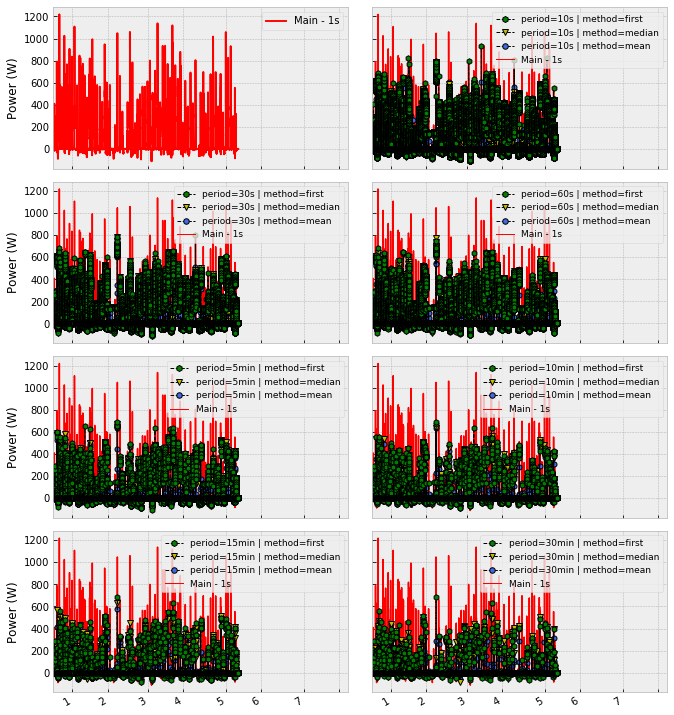

In [7]:
rcParams['figure.figsize'] = (11, 14)

t0 = '2013-05-24 05:30:00+01:00' #tiempo inicial
t1 = '2013-09-18 08:40:00+01:00' #tiempo final

labels_ = ['Main - 1s','10s','30s','60s','5min','10min','15min','30min']
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(4, 2, sharex=True, sharey=True,
                                                                   gridspec_kw={'hspace': 0.08, 'wspace': 0.08})
i = 1
for ax in fig.get_axes():   
    if ax == ax1:
        df_1s[t0:t1].plot(ax=ax,linewidth=1.9,color='r')
        ax.legend([labels_[0]])               
    else:
        import matplotlib.lines as mlines
        df_1s[t0:t1].plot(ax=ax,linewidth=1.5,color='r') 
        dfs1[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="o", markersize=5, markerfacecolor='royalblue')    
        dfs2[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="v", markersize=5.5, markerfacecolor='y')
        dfs3[i][t0:t1].plot(ax=ax,lw=1, c='k', ls='--', marker="h", markersize=5.5, markerfacecolor='g')
        #etiquetas
        line0 = mlines.Line2D([], [], lw=1, c='red', label= labels_[0])
        line1 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="o", markersize=5.5,
                              markerfacecolor='royalblue', label='period='+labels_[i]+' | method=mean')
        line2 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="v", markersize=6,
                              markerfacecolor='y', label='period='+labels_[i] + ' | method=median')
        ax.legend(handles=[line2, line1, line0], fontsize=9)
        line3 = mlines.Line2D([], [], lw=1, c='k', ls='--', marker="h", markersize=6,
                              markerfacecolor='g', label='period='+labels_[i] + ' | method=first')
        ax.legend(handles=[line3, line2, line1, line0], fontsize=9)
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
        i = i+1
    ax.set(ylabel='Power (W)')

ax1.set(xlim=('2013-05-24 05:30:00+01:00','2013-09-18 08:40:00+01:00'))
ax1.minorticks_off()
ax1.set_xticklabels(['1','2','3','4','5','6','7'])

#guarda gráfico
plt.savefig('./data/images/2.3_Resample.svg', bbox_inches='tight', transparent=True)
pass